In [1]:
# identificando os outliers para as variáveis 
def limite_quantile_outliers(data, col):
    # primeiro quartil (q1)
    q1 = data[col].quantile(.25)
    # terceiro quartil (q3)
    q3 = data[col].quantile(.75)
    # cálculo do IQR (AMPLITUDE INTERQUARTIL)
    IQR = q3 - q1

    print(f'IQR da variável {col}: ', IQR)

    # definindo os limites

    # limite superior é +1.5 vezes o valor do IQR
    sup = q3 + 1.5 * IQR
    # limite inferior é -1.5 vezes o valor do IQR
    inf = q1 - 1.5 * IQR

    print(f'Limite superior de {col}: ', sup)
    print(f'Limite inferior de {col}: ', inf)


def boxplot_outliers(data, col, val):
    # Visulizando o boxplot da coluna price
    fig, ax = plt.subplots(figsize=(15, 3))
    data['bmi'].plot(kind='box', vert=False)
    ax.set_title(f'Dataset - {col}')
    plt.show()
    print("O dataset possui {} colunas".format(data.shape[0]))
    print("{} Entradas acima de {}".format(len(data[data[col] > val]), val))
    print("Representam {:.2f}% do dataset".format(
        (len(data[data[col] > val]) / data.shape[0])*100))


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


from sklearn.ensemble import ExtraTreesRegressor


from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

2021-10-17 21:27:38.545901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 21:27:38.545974: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Stroke Prediction/data/healthcare-dataset-stroke-data.csv')

df = df.drop(['id'], axis=1)

In [210]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Analise de Outliers

In [211]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [212]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

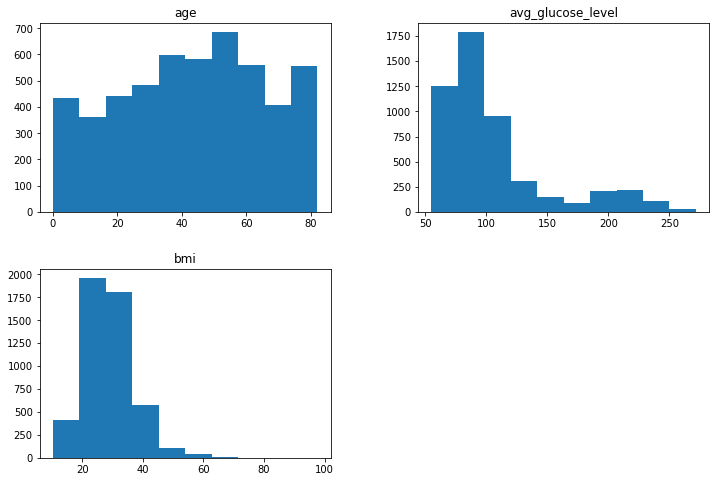

In [213]:
df[['age', 'avg_glucose_level', 'bmi']].hist(figsize=(12,8), grid=False);

In [4]:
cols = ['age', 'avg_glucose_level', 'bmi']

for col in cols:
    print(col)
    limite_quantile_outliers(df, col)
    print('\n')

age
IQR da variável age:  36.0
Limite superior de age:  115.0
Limite inferior de age:  -29.0


avg_glucose_level
IQR da variável avg_glucose_level:  36.84500000000001
Limite superior de avg_glucose_level:  169.35750000000002
Limite inferior de avg_glucose_level:  21.97749999999997


bmi
IQR da variável bmi:  9.600000000000001
Limite superior de bmi:  47.5
Limite inferior de bmi:  9.099999999999998




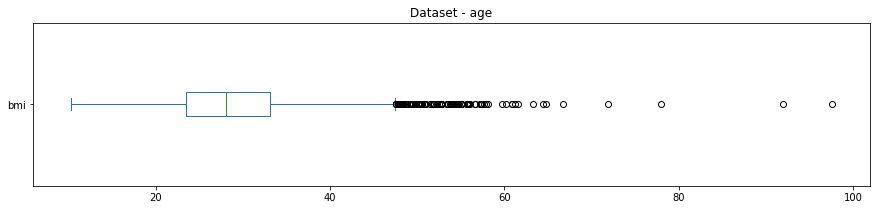

O dataset possui 5110 colunas
0 Entradas acima de 115.0
Representam 0.00% do dataset


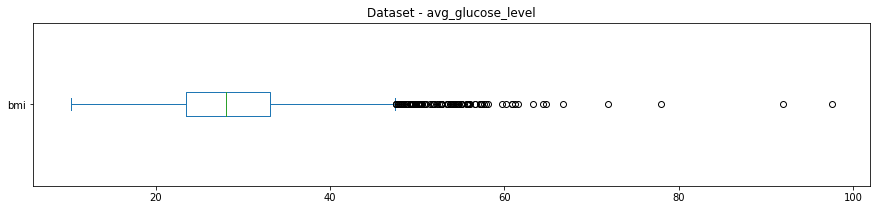

O dataset possui 5110 colunas
616 Entradas acima de 171.0125
Representam 12.05% do dataset


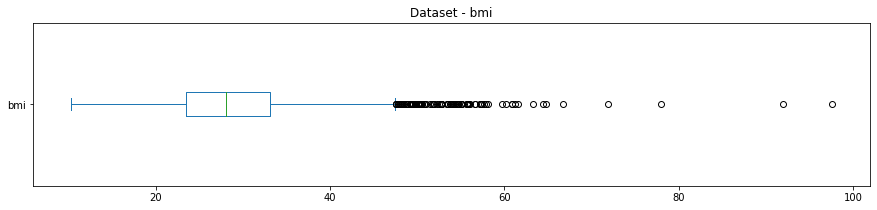

O dataset possui 5110 colunas
117 Entradas acima de 47.0
Representam 2.29% do dataset


In [5]:
valores_superior = [115.0, 171.0125, 47.0]
for (col, val) in zip(cols, valores_superior):
    boxplot_outliers(df, col, val)

## Limpando os outliers

In [71]:
data = df.drop(df[(df['avg_glucose_level'] >= 171.0125) | (df['bmi'] >= 47)].index, axis=0)
print('Foram retiradas {} linhas'.format(df.shape[0] - data.shape[0]))

Foram retiradas 703 linhas


In [98]:
X = data.drop(['stroke'], axis=1)
y = data['stroke']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, random_state=42)

In [99]:
cols = ['ever_married', 'Residence_type']
le = LabelEncoder()
for col in cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] =  le.transform(X_val[col])

/home/maksonvinicio/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [100]:
def encoder_ohe(cols_ohe, ohe, X_train, X_val):
    for col in cols_ohe:
        colunas_ohe = ohe.fit_transform(X_train[[col]])
        colunas_ohe_teste = ohe.transform(X_val[[col]])
        
        categorias_ohe = ohe.categories_[0]
        
        for indice, nome_categoria in enumerate(categorias_ohe):
            df_categorias = pd.DataFrame(data=colunas_ohe[:, indice], columns=[nome_categoria])
            df_categorias_teste = pd.DataFrame(data=colunas_ohe_teste[:, indice], columns=[nome_categoria])
            
            
            X_train[nome_categoria] = colunas_ohe[:, indice]
            X_val[nome_categoria] = colunas_ohe_teste[:, indice]
        
    
        X_train = X_train.drop(col, axis=1)
        X_val = X_val.drop(col, axis=1)

    return X_train, X_val 

In [101]:
cols_ohe = ['gender', 'work_type', 'smoking_status']
ohe = OneHotEncoder(sparse=False)
X_train, X_val = encoder_ohe(cols_ohe, ohe, X_train, X_val)

['Female' 'Male' 'Other']
['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
['Unknown' 'formerly smoked' 'never smoked' 'smokes']


/home/maksonvinicio/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Imputando valores ausentes

In [113]:
X_train.isna().sum()

age                  0
hypertension         0
heart_disease        0
ever_married         0
Residence_type       0
avg_glucose_level    0
bmi                  0
Female               0
Male                 0
Other                0
Govt_job             0
Never_worked         0
Private              0
Self-employed        0
children             0
Unknown              0
formerly smoked      0
never smoked         0
smokes               0
dtype: int64

In [111]:
estimator = ExtraTreesRegressor(n_estimators=100, random_state=42)
it_imp = IterativeImputer(estimator=estimator, missing_values=np.nan, max_iter=20)

X_train['bmi'] = it_imp.fit_transform(X_train['bmi'].values.reshape(-1, 1))
X_val['bmi'] = it_imp.transform(X_val['bmi'].values.reshape(-1, 1))

In [112]:
y_train.value_counts()

0    2540
1     104
Name: stroke, dtype: int64

In [114]:
cols_scaler = ['age', 'avg_glucose_level', 'bmi']
sc = StandardScaler()
X_train[cols_scaler] = sc.fit_transform(X_train[cols_scaler])
X_val[cols_scaler] = sc.transform(X_val[cols_scaler])

In [115]:
def FeedForward():
    model = Sequential()
    model.add(Dense(units=6, activation='relu', input_dim=19))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [119]:
model = KerasClassifier(FeedForward, epochs=10, batch_size=10, verbose=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(model, X_train, y_train, cv=cv)

array([0.96030247, 0.96030247, 0.96030247, 0.96030247, 0.96212119])

In [120]:
model.fit(X_train, y_train)

In [121]:
pred = model.predict(X_val)
pred = (pred > 0.5)

# Resultados

In [122]:
print("Relatório de Classificação:\n", classification_report(y_val, pred, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9648    1.0000    0.9821      1701
           1     0.0000    0.0000    0.0000        62

    accuracy                         0.9648      1763
   macro avg     0.4824    0.5000    0.4911      1763
weighted avg     0.9309    0.9648    0.9476      1763



/home/maksonvinicio/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


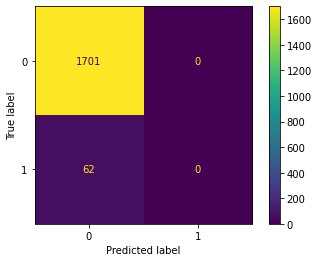

In [123]:
cm = confusion_matrix(y_val, pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

In [125]:
accuracy_score(y_val, pred)

0.9648326715825298